# Домашнее задание 2: Создание и оптимизация ResNet18

In [49]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns

from tqdm import tqdm
import zipfile

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Часть 1: Подготовка данных

 Загрузка данных датасета


In [51]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        zip_path = f'{root_dir}.zip'
        temp_extract = "./_temp_extract"

        if not os.path.exists(root_dir):
          if not os.path.exists(zip_path):
              print(f"Файл {zip_path} не найден.")
          else:
              with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                  zip_ref.extractall(temp_extract)
                  inner_folder = os.path.join(temp_extract, "tiny-imagenet-200")

                  os.makedirs(self.root_dir, exist_ok=True)
                  for item in os.listdir(inner_folder):
                      src = os.path.join(inner_folder, item)
                      dst = os.path.join(self.root_dir, item)
                      if os.path.isdir(src):
                          shutil.copytree(src, dst, dirs_exist_ok=True)
                      else:
                          shutil.copy2(src, dst)
                  shutil.rmtree(temp_extract)
                  print(f"Архив {zip_path} успешно распакован в папку {root_dir}.")

        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

class TinyImageNetSubDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = "tiny-imagenet-200"

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
test_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Train size: 100000
Test size: 10000
Классов: 200


Разделение выборки на тренировочную и валидационную

In [52]:
all_samples = train_dataset.samples
X = [x for x, y in all_samples]
y = [y for x, y in all_samples]

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")

 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов


Ограничение датасетов на 10 классов

In [53]:
selected_wnids = ['n02123045', 'n01443537',  'n01629819', 'n02206856',  'n04285008',
                  'n07749582', 'n09246464', 'n03085013', 'n02823428', 'n04008634']
selected_classes = [train_dataset.class_names.index(wnid) for wnid in selected_wnids]


subset_train_samples = [s for s in train_split_stratified if s[1] in selected_classes]
subset_val_samples = [s for s in val_split_stratified if s[1] in selected_classes]
subset_test_samples = [s for s in test_dataset.samples if s[1] in selected_classes]

print(f"Используем {len(subset_train_samples)} train, {len(subset_val_samples)} val и {len(subset_test_samples)} test изображений "
      f"из {len(selected_classes)} классов")

class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

subset_train_samples = remap_samples(subset_train_samples)
subset_val_samples = remap_samples(subset_val_samples)
subset_test_samples = remap_samples(subset_test_samples)



train_subset_dataset = TinyImageNetSubDataset(subset_train_samples, transform=train_transform)
val_subset_dataset = TinyImageNetSubDataset(subset_val_samples, transform=val_transform)
test_subset_dataset = TinyImageNetSubDataset(subset_test_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset_dataset, batch_size=len(test_subset_dataset), shuffle=False)

Используем 4000 train, 1000 val и 500 test изображений из 10 классов


In [133]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_to_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_to_word[wnid] = word

class_names_human = [wnid_to_word[wnid].split(",")[0] for wnid in selected_wnids]

## Часть 2: Базовая архитектура ResNet18

### 2.1. Реализация Basic Block

In [55]:
class BasicBlock(nn.Module):
    """
    Базовый блок ResNet с residual connection

    Args:
        in_channels (int): количество входных каналов
        out_channels (int): количество выходных каналов
        stride (int): шаг свертки (по умолчанию 1)
        downsample (nn.Module): слой для изменения размерности (если нужно)
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, activation="relu"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        match activation:
            case "relu":
                self.activation = nn.ReLU(inplace=True)
            case "leakyrelu":
                self.activation = nn.LeakyReLU(inplace=True)
            case "elu":
                self.activation = nn.ELU(inplace=True)
            case "gelu":
                self.activation = nn.GELU()
            case _:
                self.activation = nn.ReLU(inplace=True)

        self.downsample = nn.Identity()
        if (in_channels != out_channels) or (downsample != None):
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x_in = self.downsample(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += x_in
        out = self.activation(out)
        return out

### 2.2. Реализация ResNet18

In [56]:
class SimpleResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.basic_block_1_0 = BasicBlock(64, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 512, 2)
        self.basic_block_4_1 = BasicBlock(512, 512)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [57]:
model = SimpleResNet18()
test_input = torch.randn(1, 3, 64, 64)
output = model(test_input)
print(output.shape)

torch.Size([1, 10])


In [58]:
total_params = sum(p.numel() for p in model.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 11,173,962


### 2.3. Ограничения для базовой модели

In [59]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.basic_block_4_0 = BasicBlock(256, 256)
        self.basic_block_4_1 = BasicBlock(256, 200)


        self.fc = nn.Linear(200, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [66]:
model_base = BaseModel()
test_input = torch.randn(1, 3, 64, 64)
output = model_base(test_input)
print(output.shape)

torch.Size([1, 10])


In [67]:
total_params = sum(p.numel() for p in model_base.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,794,314


### 2.4. Скрипт обучения


In [68]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одной эпохи обучения

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        predicted = model(data)

        loss = criterion(predicted, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        total += target.size(0)
        correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

In [69]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели

    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)

    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device)
          predicted = model(data)

          loss = criterion(predicted, target)
          running_loss += loss.item()

          total += target.size(0)
          correct += (predicted.argmax(dim=1) == target).sum().item()

    return running_loss / len(val_loader), 100 * correct / total

In [70]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_path='best_model.pth'):
    """
    Основная функция для обучения модели

    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох

    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    model = model.to(device)

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")


    return history



In [71]:
optimizer = torch.optim.Adam(model_base.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_base = train_model(
    model=model_base,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_base.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]


 Train Loss: 1.7620, Train Acc: 37.38%
 Val Loss: 2.2196, Val Acc: 35.60%
 Сохранена лучшая модель с точностью 35.60%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s]


 Train Loss: 1.4788, Train Acc: 48.83%
 Val Loss: 1.6049, Val Acc: 45.30%
 Сохранена лучшая модель с точностью 45.30%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.28it/s]


 Train Loss: 1.3492, Train Acc: 53.88%
 Val Loss: 1.4155, Val Acc: 51.80%
 Сохранена лучшая модель с точностью 51.80%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.09it/s]


 Train Loss: 1.2465, Train Acc: 59.00%
 Val Loss: 1.2628, Val Acc: 57.10%
 Сохранена лучшая модель с точностью 57.10%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.55it/s]


 Train Loss: 1.1278, Train Acc: 62.05%
 Val Loss: 2.1312, Val Acc: 43.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.49it/s]


 Train Loss: 1.0647, Train Acc: 65.00%
 Val Loss: 1.2835, Val Acc: 57.30%
 Сохранена лучшая модель с точностью 57.30%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.33it/s]


 Train Loss: 0.9940, Train Acc: 66.85%
 Val Loss: 1.0641, Val Acc: 63.80%
 Сохранена лучшая модель с точностью 63.80%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.18it/s]


 Train Loss: 0.9088, Train Acc: 69.45%
 Val Loss: 1.3022, Val Acc: 59.60%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.26it/s]


 Train Loss: 0.8980, Train Acc: 69.83%
 Val Loss: 1.2524, Val Acc: 59.20%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.05it/s]


 Train Loss: 0.8176, Train Acc: 72.38%
 Val Loss: 0.9755, Val Acc: 65.80%
 Сохранена лучшая модель с точностью 65.80%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.54it/s]


 Train Loss: 0.7893, Train Acc: 73.97%
 Val Loss: 1.0719, Val Acc: 64.40%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.85it/s]


 Train Loss: 0.7387, Train Acc: 75.53%
 Val Loss: 1.3943, Val Acc: 61.10%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.96it/s]


 Train Loss: 0.7387, Train Acc: 74.97%
 Val Loss: 0.8825, Val Acc: 70.10%
 Сохранена лучшая модель с точностью 70.10%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.95it/s]


 Train Loss: 0.6599, Train Acc: 78.60%
 Val Loss: 0.8992, Val Acc: 69.30%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]


 Train Loss: 0.6011, Train Acc: 79.17%
 Val Loss: 1.1292, Val Acc: 68.40%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.97it/s]


 Train Loss: 0.5777, Train Acc: 81.25%
 Val Loss: 0.9047, Val Acc: 71.10%
 Сохранена лучшая модель с точностью 71.10%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.67it/s]


 Train Loss: 0.5712, Train Acc: 80.58%
 Val Loss: 1.1430, Val Acc: 65.40%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.57it/s]


 Train Loss: 0.5166, Train Acc: 82.67%
 Val Loss: 0.9398, Val Acc: 70.70%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]


 Train Loss: 0.4734, Train Acc: 84.33%
 Val Loss: 1.0257, Val Acc: 68.10%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.92it/s]


 Train Loss: 0.4396, Train Acc: 85.20%
 Val Loss: 1.0112, Val Acc: 69.30%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]


 Train Loss: 0.4095, Train Acc: 86.53%
 Val Loss: 1.3465, Val Acc: 65.60%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.94it/s]


 Train Loss: 0.4030, Train Acc: 86.55%
 Val Loss: 1.1213, Val Acc: 68.20%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]


 Train Loss: 0.3289, Train Acc: 89.20%
 Val Loss: 1.0203, Val Acc: 69.40%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]


 Train Loss: 0.3122, Train Acc: 89.70%
 Val Loss: 1.0083, Val Acc: 70.20%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.23it/s]

 Train Loss: 0.2415, Train Acc: 92.45%
 Val Loss: 0.8646, Val Acc: 73.50%
 Сохранена лучшая модель с точностью 73.50%


### 2.5: Визуализация базовых результатов

In [72]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax1.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax1.plot(np.arange(1, len(history['val_acc'])-1, 1), np.convolve(history['val_acc'], np.ones(3)/3, mode='valid'), label='Smooth val acc', color='red', alpha=0.3 )
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_loss'], label='Train Loss', color='blue')
    ax2.plot(history['val_loss'], label='Validation Loss', color='red')
    ax2.plot(np.arange(1, len(history['val_loss'])-1, 1), np.convolve(history['val_loss'], np.ones(3)/3, mode='valid'), label='Smooth val loss', color='red', alpha=0.3 )
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)


    plt.tight_layout()
    plt.show()

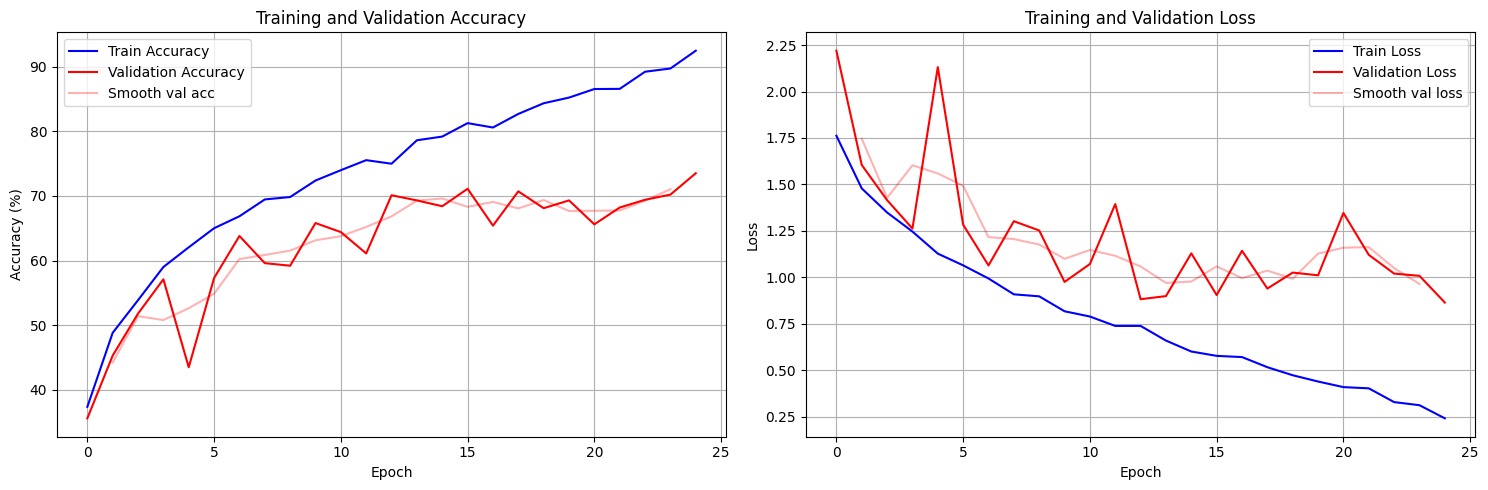

In [73]:
plot_training_history(history_base)

In [74]:
total_params = sum(p.numel() for p in model_base.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,794,314


In [75]:
print(model_base)

BaseModel(
  (basic_block_1_0): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (basic_block_1_1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=

## Часть 3: Поэтапная оптимизация модели

### 3.1: Оптимизация количества каналов

In [76]:
class Model31A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 32)
        self.basic_block_1_1 = BasicBlock(32, 32)

        self.basic_block_2_0 = BasicBlock(32, 64, 2)
        self.basic_block_2_1 = BasicBlock(64, 64)

        self.basic_block_3_0 = BasicBlock(64, 128, 2)
        self.basic_block_3_1 = BasicBlock(128, 128)

        self.basic_block_4_0 = BasicBlock(128, 256, 2)
        self.basic_block_4_1 = BasicBlock(256, 256)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))
        x = self.basic_block_4_1(self.basic_block_4_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [77]:
model_3_1_A = Model31A()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_1_A(test_input)
print(output.shape)

torch.Size([1, 10])


In [78]:
total_params = sum(p.numel() for p in model_3_1_A.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 2,788,490


In [79]:
optimizer = torch.optim.Adam(model_3_1_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_1_A = train_model(
    model=model_3_1_A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_31A.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.97it/s]


 Train Loss: 1.7247, Train Acc: 40.73%
 Val Loss: 3.1743, Val Acc: 31.50%
 Сохранена лучшая модель с точностью 31.50%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.08it/s]


 Train Loss: 1.3712, Train Acc: 52.12%
 Val Loss: 1.5896, Val Acc: 46.70%
 Сохранена лучшая модель с точностью 46.70%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


 Train Loss: 1.1894, Train Acc: 59.85%
 Val Loss: 1.4624, Val Acc: 51.30%
 Сохранена лучшая модель с точностью 51.30%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.56it/s]


 Train Loss: 1.1038, Train Acc: 62.42%
 Val Loss: 1.1704, Val Acc: 58.70%
 Сохранена лучшая модель с точностью 58.70%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.18it/s]


 Train Loss: 0.9695, Train Acc: 68.08%
 Val Loss: 1.3159, Val Acc: 58.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.94it/s]


 Train Loss: 0.9216, Train Acc: 69.22%
 Val Loss: 1.3321, Val Acc: 57.80%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.53it/s]


 Train Loss: 0.8547, Train Acc: 71.47%
 Val Loss: 0.9740, Val Acc: 67.00%
 Сохранена лучшая модель с точностью 67.00%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.99it/s]


 Train Loss: 0.7817, Train Acc: 73.78%
 Val Loss: 1.1306, Val Acc: 63.50%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.60it/s]


 Train Loss: 0.7266, Train Acc: 75.38%
 Val Loss: 0.9051, Val Acc: 71.50%
 Сохранена лучшая модель с точностью 71.50%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.29it/s]


 Train Loss: 0.6340, Train Acc: 79.10%
 Val Loss: 0.9823, Val Acc: 69.10%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.50it/s]


 Train Loss: 0.6179, Train Acc: 79.08%
 Val Loss: 0.8317, Val Acc: 71.50%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.83it/s]


 Train Loss: 0.5608, Train Acc: 81.28%
 Val Loss: 1.1764, Val Acc: 65.60%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.10it/s]


 Train Loss: 0.4920, Train Acc: 83.78%
 Val Loss: 0.8952, Val Acc: 71.30%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.33it/s]


 Train Loss: 0.4306, Train Acc: 85.42%
 Val Loss: 0.9133, Val Acc: 71.80%
 Сохранена лучшая модель с точностью 71.80%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.27it/s]


 Train Loss: 0.3805, Train Acc: 87.28%
 Val Loss: 1.3174, Val Acc: 65.10%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.03it/s]


 Train Loss: 0.3156, Train Acc: 89.35%
 Val Loss: 1.2672, Val Acc: 67.30%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.16it/s]


 Train Loss: 0.3150, Train Acc: 89.42%
 Val Loss: 1.3713, Val Acc: 64.40%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.04it/s]


 Train Loss: 0.2763, Train Acc: 90.70%
 Val Loss: 1.0724, Val Acc: 72.00%
 Сохранена лучшая модель с точностью 72.00%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.88it/s]


 Train Loss: 0.2088, Train Acc: 93.62%
 Val Loss: 0.9754, Val Acc: 71.20%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.84it/s]


 Train Loss: 0.1565, Train Acc: 95.35%
 Val Loss: 1.3137, Val Acc: 66.50%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.27it/s]


 Train Loss: 0.1172, Train Acc: 96.75%
 Val Loss: 1.0584, Val Acc: 71.80%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.11it/s]


 Train Loss: 0.1127, Train Acc: 96.67%
 Val Loss: 1.4531, Val Acc: 68.70%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.73it/s]


 Train Loss: 0.0721, Train Acc: 98.20%
 Val Loss: 1.2582, Val Acc: 71.80%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.55it/s]


 Train Loss: 0.0757, Train Acc: 97.83%
 Val Loss: 1.0499, Val Acc: 72.60%
 Сохранена лучшая модель с точностью 72.60%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.09it/s]

 Train Loss: 0.0685, Train Acc: 98.33%
 Val Loss: 1.1601, Val Acc: 72.40%


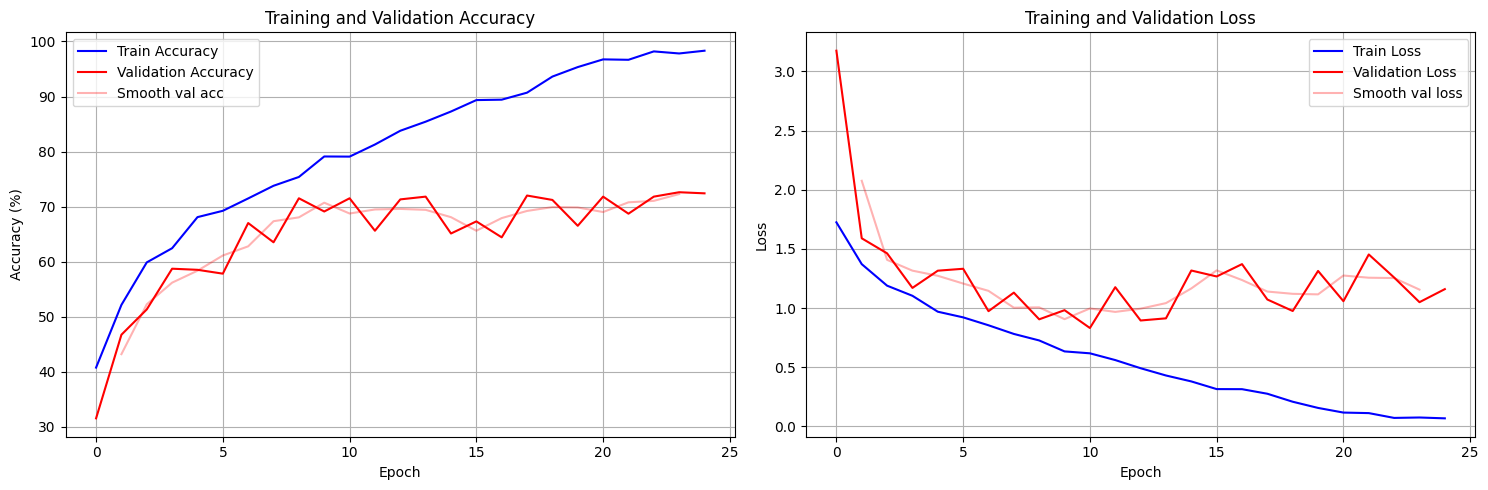

In [80]:
plot_training_history(history_3_1_A)

In [81]:
class Model31B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64)
        self.basic_block_1_1 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [82]:
model_3_1_B = Model31B()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_1_B(test_input)
print(output.shape)

torch.Size([1, 10])


In [83]:
total_params = sum(p.numel() for p in model_3_1_B.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 2,741,002


In [84]:
optimizer = torch.optim.Adam(model_3_1_B.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_1_B = train_model(
    model=model_3_1_B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_31B.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


 Train Loss: 1.7432, Train Acc: 40.48%
 Val Loss: 1.7247, Val Acc: 38.90%
 Сохранена лучшая модель с точностью 38.90%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 1.4267, Train Acc: 51.50%
 Val Loss: 1.6880, Val Acc: 46.20%
 Сохранена лучшая модель с точностью 46.20%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.77it/s]


 Train Loss: 1.2869, Train Acc: 56.73%
 Val Loss: 1.3080, Val Acc: 54.40%
 Сохранена лучшая модель с точностью 54.40%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


 Train Loss: 1.1474, Train Acc: 62.12%
 Val Loss: 1.2282, Val Acc: 58.70%
 Сохранена лучшая модель с точностью 58.70%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


 Train Loss: 1.0476, Train Acc: 65.72%
 Val Loss: 1.7114, Val Acc: 50.70%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.03it/s]


 Train Loss: 0.9515, Train Acc: 68.67%
 Val Loss: 1.3816, Val Acc: 57.00%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


 Train Loss: 0.8970, Train Acc: 69.65%
 Val Loss: 1.3765, Val Acc: 58.40%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


 Train Loss: 0.8348, Train Acc: 72.15%
 Val Loss: 1.1096, Val Acc: 62.90%
 Сохранена лучшая модель с точностью 62.90%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.67it/s]


 Train Loss: 0.7892, Train Acc: 73.50%
 Val Loss: 2.4165, Val Acc: 50.60%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.57it/s]


 Train Loss: 0.7339, Train Acc: 75.62%
 Val Loss: 1.2364, Val Acc: 60.70%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.77it/s]


 Train Loss: 0.7078, Train Acc: 77.17%
 Val Loss: 1.4051, Val Acc: 61.10%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


 Train Loss: 0.6493, Train Acc: 78.60%
 Val Loss: 0.8791, Val Acc: 71.90%
 Сохранена лучшая модель с точностью 71.90%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


 Train Loss: 0.6172, Train Acc: 79.88%
 Val Loss: 0.9738, Val Acc: 69.60%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


 Train Loss: 0.5888, Train Acc: 80.40%
 Val Loss: 0.9241, Val Acc: 70.70%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.43it/s]


 Train Loss: 0.5526, Train Acc: 81.33%
 Val Loss: 1.1541, Val Acc: 65.10%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.43it/s]


 Train Loss: 0.5310, Train Acc: 83.03%
 Val Loss: 1.0173, Val Acc: 70.00%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.47it/s]


 Train Loss: 0.4510, Train Acc: 85.28%
 Val Loss: 1.5066, Val Acc: 58.30%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.45it/s]


 Train Loss: 0.4509, Train Acc: 85.65%
 Val Loss: 0.8431, Val Acc: 74.30%
 Сохранена лучшая модель с точностью 74.30%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.52it/s]


 Train Loss: 0.4291, Train Acc: 86.20%
 Val Loss: 0.9832, Val Acc: 70.60%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.67it/s]


 Train Loss: 0.3979, Train Acc: 86.80%
 Val Loss: 2.2691, Val Acc: 56.00%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.27it/s]


 Train Loss: 0.3753, Train Acc: 88.25%
 Val Loss: 1.0379, Val Acc: 73.80%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


 Train Loss: 0.3900, Train Acc: 87.17%
 Val Loss: 1.3793, Val Acc: 66.10%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.81it/s]


 Train Loss: 0.3020, Train Acc: 90.33%
 Val Loss: 1.0710, Val Acc: 68.70%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.92it/s]


 Train Loss: 0.2728, Train Acc: 91.05%
 Val Loss: 1.0437, Val Acc: 69.50%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.65it/s]

 Train Loss: 0.2286, Train Acc: 92.80%
 Val Loss: 0.7869, Val Acc: 77.60%
 Сохранена лучшая модель с точностью 77.60%


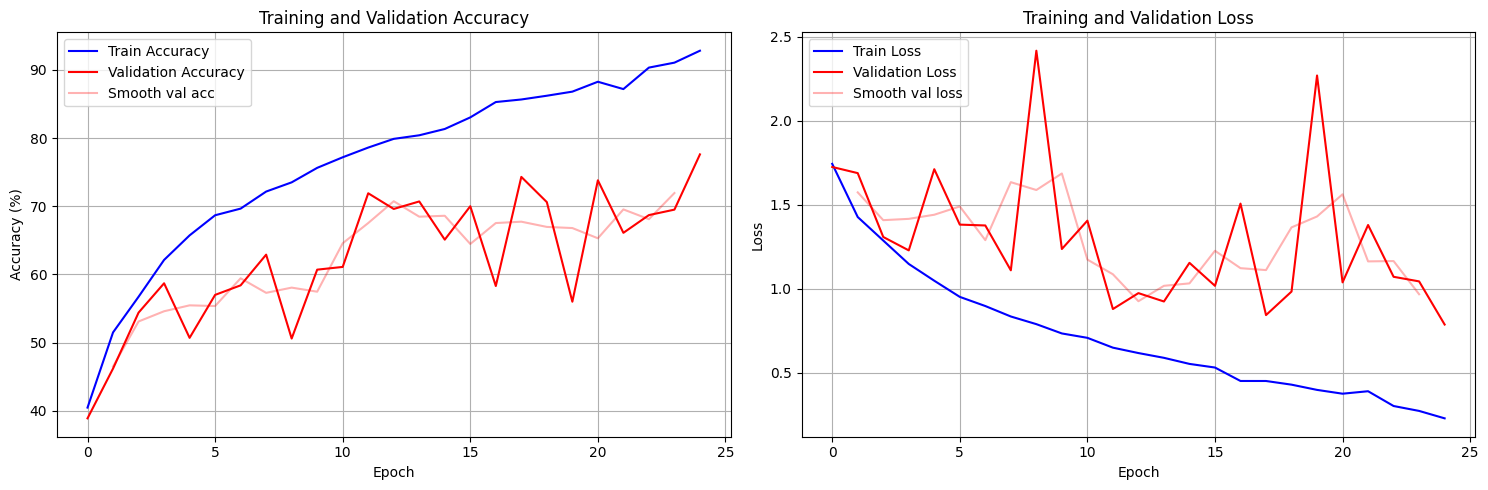

In [85]:
plot_training_history(history_3_1_B)

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) | Train Accuracy (%) |
|------|---------------|---------------|------------------|--------------------|
| 3.1  |3.1-A          | 2 788 490     | 72.60            | 97.83              |
| 3.1  |3.1-B          | 2 741 002     | 77.60            | 92.80              |

**Вывод:** лучше конфигурация 3.1-B, хотя у неё мень параметров, она дала лучше результат по val accuracy. Также заметно начало переобучения у модели 3.1-A после ~13 эпохи.

### 3.2: Эксперименты с количеством residual блоков

In [86]:
class Model32A(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64)
        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_3_0 = BasicBlock(128, 256, 2)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_0(x)
        x = self.basic_block_2_0(x)
        x = self.basic_block_3_0(x)

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [87]:
model_3_2_A = Model32A()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_2_A(test_input)
print(output.shape)

torch.Size([1, 10])


In [88]:
total_params = sum(p.numel() for p in model_3_2_A.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 1,190,922


In [89]:
optimizer = torch.optim.Adam(model_3_2_A.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_2_A = train_model(
    model=model_3_2_A,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_32A.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.23it/s]


 Train Loss: 1.6621, Train Acc: 43.38%
 Val Loss: 1.5024, Val Acc: 48.10%
 Сохранена лучшая модель с точностью 48.10%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.23it/s]


 Train Loss: 1.3461, Train Acc: 54.65%
 Val Loss: 1.3684, Val Acc: 53.30%
 Сохранена лучшая модель с точностью 53.30%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.44it/s]


 Train Loss: 1.2172, Train Acc: 59.95%
 Val Loss: 1.2920, Val Acc: 56.90%
 Сохранена лучшая модель с точностью 56.90%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.40it/s]


 Train Loss: 1.1133, Train Acc: 63.00%
 Val Loss: 1.3039, Val Acc: 56.50%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.16it/s]


 Train Loss: 1.0384, Train Acc: 65.72%
 Val Loss: 1.3459, Val Acc: 57.00%
 Сохранена лучшая модель с точностью 57.00%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.41it/s]


 Train Loss: 0.9484, Train Acc: 68.85%
 Val Loss: 1.5043, Val Acc: 51.60%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.21it/s]


 Train Loss: 0.8968, Train Acc: 70.35%
 Val Loss: 1.1521, Val Acc: 64.50%
 Сохранена лучшая модель с точностью 64.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.61it/s]


 Train Loss: 0.8365, Train Acc: 72.92%
 Val Loss: 1.2059, Val Acc: 57.50%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.14it/s]


 Train Loss: 0.8112, Train Acc: 73.30%
 Val Loss: 1.2627, Val Acc: 61.40%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.40it/s]


 Train Loss: 0.7583, Train Acc: 74.92%
 Val Loss: 1.1745, Val Acc: 64.60%
 Сохранена лучшая модель с точностью 64.60%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


 Train Loss: 0.6914, Train Acc: 77.47%
 Val Loss: 1.2004, Val Acc: 64.40%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


 Train Loss: 0.6795, Train Acc: 77.42%
 Val Loss: 0.9298, Val Acc: 69.60%
 Сохранена лучшая модель с точностью 69.60%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.13it/s]


 Train Loss: 0.6594, Train Acc: 78.65%
 Val Loss: 1.0398, Val Acc: 66.90%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.49it/s]


 Train Loss: 0.6023, Train Acc: 80.65%
 Val Loss: 0.8792, Val Acc: 70.30%
 Сохранена лучшая модель с точностью 70.30%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.40it/s]


 Train Loss: 0.5686, Train Acc: 82.55%
 Val Loss: 0.9203, Val Acc: 71.30%
 Сохранена лучшая модель с точностью 71.30%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.53it/s]


 Train Loss: 0.5284, Train Acc: 83.50%
 Val Loss: 1.0867, Val Acc: 66.40%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.78it/s]


 Train Loss: 0.4838, Train Acc: 83.85%
 Val Loss: 0.8758, Val Acc: 72.50%
 Сохранена лучшая модель с точностью 72.50%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.92it/s]


 Train Loss: 0.4528, Train Acc: 85.30%
 Val Loss: 1.1972, Val Acc: 65.10%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.85it/s]


 Train Loss: 0.4575, Train Acc: 85.10%
 Val Loss: 0.8429, Val Acc: 73.30%
 Сохранена лучшая модель с точностью 73.30%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.70it/s]


 Train Loss: 0.4155, Train Acc: 86.67%
 Val Loss: 0.9162, Val Acc: 71.90%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.53it/s]


 Train Loss: 0.3932, Train Acc: 87.08%
 Val Loss: 1.1701, Val Acc: 69.40%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.61it/s]


 Train Loss: 0.3365, Train Acc: 89.28%
 Val Loss: 1.2662, Val Acc: 69.10%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.09it/s]


 Train Loss: 0.3335, Train Acc: 89.97%
 Val Loss: 1.0751, Val Acc: 66.80%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 19.36it/s]


 Train Loss: 0.2959, Train Acc: 90.42%
 Val Loss: 0.7565, Val Acc: 76.70%
 Сохранена лучшая модель с точностью 76.70%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.16it/s]

 Train Loss: 0.2533, Train Acc: 92.33%
 Val Loss: 1.4293, Val Acc: 65.90%


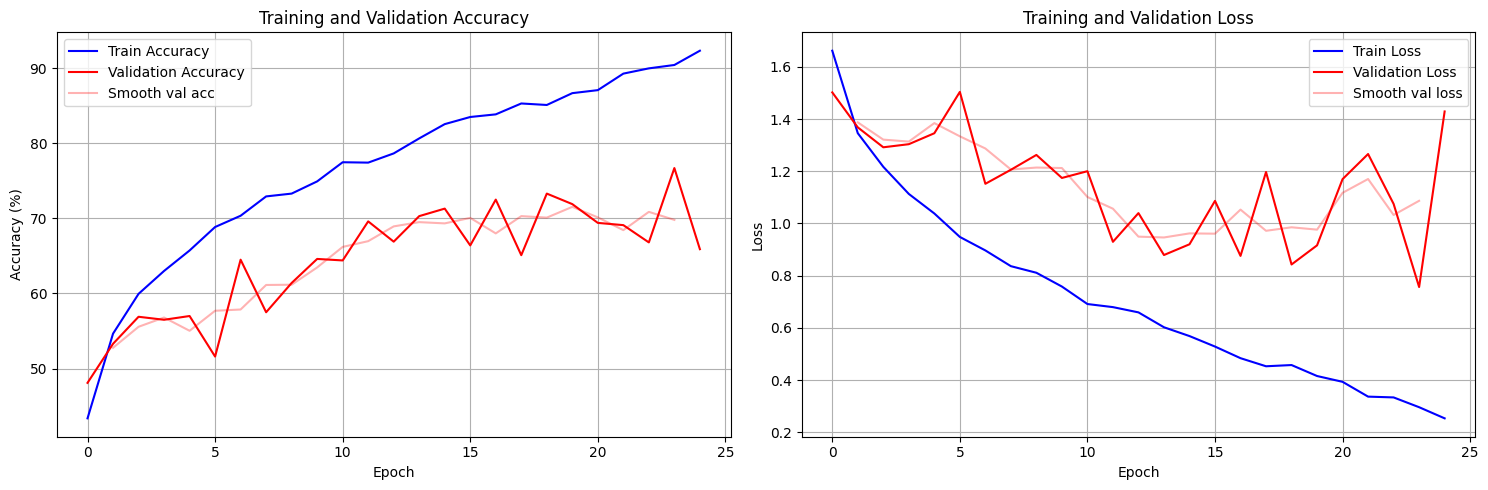

In [90]:
plot_training_history(history_3_2_A)

In [91]:
class Model32C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64, 2)
        self.basic_block_1_1 = BasicBlock(64, 64)
        self.basic_block_1_2 = BasicBlock(64, 64)

        self.basic_block_2_0 = BasicBlock(64, 128, 2)
        self.basic_block_2_1 = BasicBlock(128, 128)
        self.basic_block_2_2 = BasicBlock(128, 128)

        self.basic_block_3_0 = BasicBlock(128, 256, 2)
        self.basic_block_3_1 = BasicBlock(256, 256)
        self.basic_block_3_2 = BasicBlock(256, 256)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_2(self.basic_block_1_1(self.basic_block_1_0(x)))
        x = self.basic_block_2_2(self.basic_block_2_1(self.basic_block_2_0(x)))
        x = self.basic_block_3_2(self.basic_block_3_1(self.basic_block_3_0(x)))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [92]:
model_3_2_C = Model32C()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_2_C(test_input)
print(output.shape)

torch.Size([1, 10])


In [93]:
total_params = sum(p.numel() for p in model_3_2_C.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 4,291,082


In [94]:
optimizer = torch.optim.Adam(model_3_2_C.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_2_C = train_model(
    model=model_3_2_C,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_32C.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.40it/s]


 Train Loss: 1.7908, Train Acc: 37.62%
 Val Loss: 1.6872, Val Acc: 43.10%
 Сохранена лучшая модель с точностью 43.10%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.84it/s]


 Train Loss: 1.4413, Train Acc: 51.40%
 Val Loss: 1.7170, Val Acc: 44.60%
 Сохранена лучшая модель с точностью 44.60%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 16.98it/s]


 Train Loss: 1.2902, Train Acc: 55.98%
 Val Loss: 1.3170, Val Acc: 56.50%
 Сохранена лучшая модель с точностью 56.50%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.85it/s]


 Train Loss: 1.1568, Train Acc: 60.50%
 Val Loss: 1.3637, Val Acc: 55.00%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.52it/s]


 Train Loss: 1.0686, Train Acc: 64.33%
 Val Loss: 1.2874, Val Acc: 56.60%
 Сохранена лучшая модель с точностью 56.60%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.58it/s]


 Train Loss: 0.9827, Train Acc: 66.97%
 Val Loss: 1.2379, Val Acc: 59.40%
 Сохранена лучшая модель с точностью 59.40%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.71it/s]


 Train Loss: 0.8814, Train Acc: 70.15%
 Val Loss: 1.3422, Val Acc: 57.00%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.17it/s]


 Train Loss: 0.8256, Train Acc: 72.92%
 Val Loss: 0.9959, Val Acc: 68.20%
 Сохранена лучшая модель с точностью 68.20%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.83it/s]


 Train Loss: 0.7993, Train Acc: 72.35%
 Val Loss: 0.9918, Val Acc: 67.50%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.28it/s]


 Train Loss: 0.6752, Train Acc: 77.28%
 Val Loss: 1.5114, Val Acc: 58.70%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.18it/s]


 Train Loss: 0.6926, Train Acc: 76.60%
 Val Loss: 0.9828, Val Acc: 68.30%
 Сохранена лучшая модель с точностью 68.30%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 22.21it/s]


 Train Loss: 0.6164, Train Acc: 78.47%
 Val Loss: 1.3102, Val Acc: 61.60%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 18.13it/s]


 Train Loss: 0.5484, Train Acc: 81.38%
 Val Loss: 0.8581, Val Acc: 72.70%
 Сохранена лучшая модель с точностью 72.70%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


 Train Loss: 0.5226, Train Acc: 82.58%
 Val Loss: 1.0702, Val Acc: 68.90%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.38it/s]


 Train Loss: 0.4706, Train Acc: 83.40%
 Val Loss: 1.2315, Val Acc: 66.00%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


 Train Loss: 0.4072, Train Acc: 86.38%
 Val Loss: 1.2018, Val Acc: 69.40%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.86it/s]


 Train Loss: 0.3746, Train Acc: 87.00%
 Val Loss: 0.9347, Val Acc: 71.20%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.76it/s]


 Train Loss: 0.3077, Train Acc: 89.78%
 Val Loss: 1.0645, Val Acc: 72.70%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.38it/s]


 Train Loss: 0.2822, Train Acc: 90.20%
 Val Loss: 0.9403, Val Acc: 73.10%
 Сохранена лучшая модель с точностью 73.10%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 20.84it/s]


 Train Loss: 0.2255, Train Acc: 92.83%
 Val Loss: 1.1666, Val Acc: 69.30%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.32it/s]


 Train Loss: 0.2329, Train Acc: 91.80%
 Val Loss: 1.4758, Val Acc: 64.70%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.62it/s]


 Train Loss: 0.2017, Train Acc: 93.08%
 Val Loss: 1.0334, Val Acc: 73.60%
 Сохранена лучшая модель с точностью 73.60%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.38it/s]


 Train Loss: 0.1262, Train Acc: 95.95%
 Val Loss: 1.6140, Val Acc: 65.70%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 21.75it/s]


 Train Loss: 0.1817, Train Acc: 94.08%
 Val Loss: 1.0031, Val Acc: 74.70%
 Сохранена лучшая модель с точностью 74.70%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:00<00:00, 17.52it/s]

 Train Loss: 0.1467, Train Acc: 95.25%
 Val Loss: 1.4045, Val Acc: 69.00%


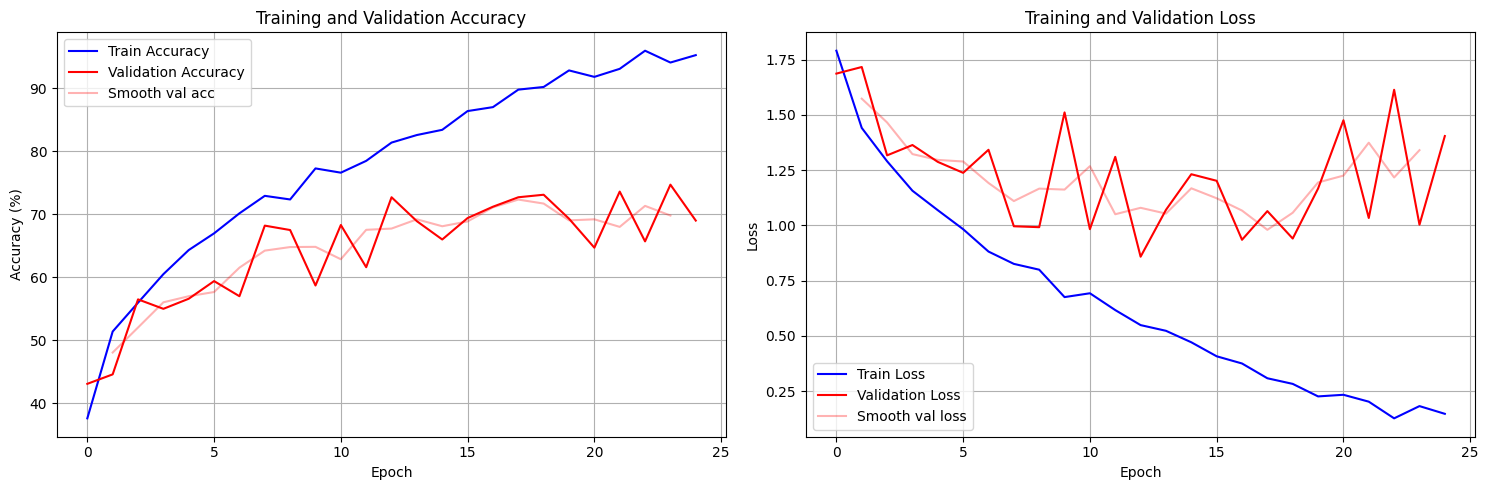

In [95]:
plot_training_history(history_3_2_C)

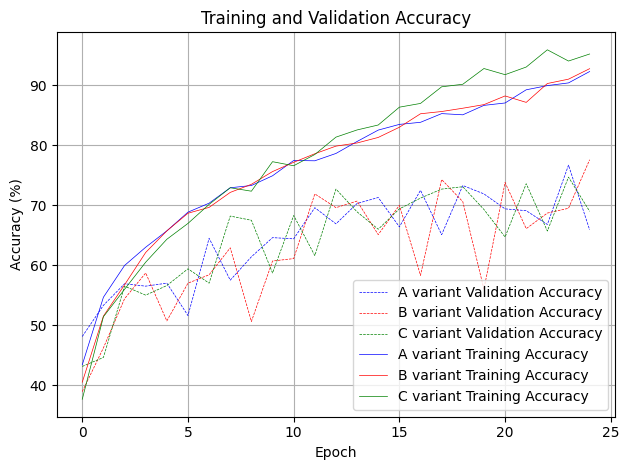

In [96]:
plt.plot(history_3_2_A['val_acc'], label='A variant Validation Accuracy', color='blue', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_1_B['val_acc'], label='B variant Validation Accuracy', color='red', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_2_C['val_acc'], label='C variant Validation Accuracy', color='green', linewidth=0.5, linestyle="dashed")

plt.plot(history_3_2_A['train_acc'], label='A variant Training Accuracy', color='blue', linewidth=0.5)
plt.plot(history_3_1_B['train_acc'], label='B variant Training Accuracy', color='red', linewidth=0.5)
plt.plot(history_3_2_C['train_acc'], label='C variant Training Accuracy', color='green', linewidth=0.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Вариант B - это модель из 3.1

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) |Train Accuracy (%) |Эпоха с лучшим результатом|
|------|---------------|---------------|------------------|-------------------|--------------------------|
| 3.2  |3.2-A          | 1 190 922     | 76.7             | 90.42             |24                        |
| 3.2  |3.2-B          | 2 741 002     | 77.6             | 92.80             |25                        |
| 3.2  |3.2-C          | 4 291 082     | 74.7             | 94.08             |24                        |

**Вывод:** модель 3.2-B с 2 блоками оптимальна, у неё валидационная точность выше и в отличие от более глубокой модели с 3 блоками, которая переобучилась.

### 3.3: Эксперименты с функциями активации

In [97]:
class Model33B(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64, activation="leakyrelu")
        self.basic_block_1_1 = BasicBlock(64, 64, activation="leakyrelu")

        self.basic_block_2_0 = BasicBlock(64, 128, 2, activation="leakyrelu")
        self.basic_block_2_1 = BasicBlock(128, 128, activation="leakyrelu")

        self.basic_block_3_0 = BasicBlock(128, 256, 2, activation="leakyrelu")
        self.basic_block_3_1 = BasicBlock(256, 256, activation="leakyrelu")

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [98]:
model_3_3_B = Model33B()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_B(test_input)
print(output.shape)

torch.Size([1, 10])


In [99]:
total_params = sum(p.numel() for p in model_3_3_B.parameters())
print(f" Всего параметров: {total_params:,}")

 Всего параметров: 2,741,002


In [100]:
optimizer = torch.optim.Adam(model_3_3_B.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_B = train_model(
    model=model_3_3_B,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33B.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.10it/s]


 Train Loss: 1.7847, Train Acc: 37.60%
 Val Loss: 1.9219, Val Acc: 40.80%
 Сохранена лучшая модель с точностью 40.80%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.32it/s]


 Train Loss: 1.4631, Train Acc: 48.98%
 Val Loss: 1.4599, Val Acc: 50.90%
 Сохранена лучшая модель с точностью 50.90%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.62it/s]


 Train Loss: 1.3261, Train Acc: 55.42%
 Val Loss: 1.8155, Val Acc: 44.70%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.18it/s]


 Train Loss: 1.1965, Train Acc: 60.48%
 Val Loss: 1.3306, Val Acc: 55.30%
 Сохранена лучшая модель с точностью 55.30%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


 Train Loss: 1.1062, Train Acc: 63.40%
 Val Loss: 1.1200, Val Acc: 63.50%
 Сохранена лучшая модель с точностью 63.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


 Train Loss: 1.0183, Train Acc: 66.88%
 Val Loss: 1.1555, Val Acc: 61.40%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.55it/s]


 Train Loss: 0.9735, Train Acc: 67.47%
 Val Loss: 1.2270, Val Acc: 60.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


 Train Loss: 0.9300, Train Acc: 69.20%
 Val Loss: 1.2947, Val Acc: 61.70%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.47it/s]


 Train Loss: 0.8528, Train Acc: 71.55%
 Val Loss: 1.1185, Val Acc: 65.00%
 Сохранена лучшая модель с точностью 65.00%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.63it/s]


 Train Loss: 0.8027, Train Acc: 73.45%
 Val Loss: 1.0867, Val Acc: 66.60%
 Сохранена лучшая модель с точностью 66.60%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


 Train Loss: 0.7867, Train Acc: 73.62%
 Val Loss: 1.1062, Val Acc: 63.50%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


 Train Loss: 0.7273, Train Acc: 75.80%
 Val Loss: 0.9745, Val Acc: 68.50%
 Сохранена лучшая модель с точностью 68.50%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.70it/s]


 Train Loss: 0.7007, Train Acc: 76.75%
 Val Loss: 1.1353, Val Acc: 64.60%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


 Train Loss: 0.6916, Train Acc: 77.40%
 Val Loss: 1.0211, Val Acc: 67.70%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.53it/s]


 Train Loss: 0.6278, Train Acc: 79.12%
 Val Loss: 1.1107, Val Acc: 65.90%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


 Train Loss: 0.6239, Train Acc: 79.40%
 Val Loss: 0.8922, Val Acc: 71.90%
 Сохранена лучшая модель с точностью 71.90%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.60it/s]


 Train Loss: 0.5588, Train Acc: 82.05%
 Val Loss: 0.8477, Val Acc: 73.10%
 Сохранена лучшая модель с точностью 73.10%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.55it/s]


 Train Loss: 0.5567, Train Acc: 81.22%
 Val Loss: 1.5417, Val Acc: 57.60%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.56it/s]


 Train Loss: 0.5344, Train Acc: 82.00%
 Val Loss: 1.0443, Val Acc: 68.60%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.33it/s]


 Train Loss: 0.4953, Train Acc: 83.08%
 Val Loss: 0.8834, Val Acc: 72.30%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 11.35it/s]


 Train Loss: 0.4895, Train Acc: 84.12%
 Val Loss: 1.0779, Val Acc: 68.00%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:01<00:00,  8.97it/s]


 Train Loss: 0.4685, Train Acc: 84.58%
 Val Loss: 1.5467, Val Acc: 62.00%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.20it/s]


 Train Loss: 0.4297, Train Acc: 85.42%
 Val Loss: 0.8183, Val Acc: 73.90%
 Сохранена лучшая модель с точностью 73.90%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


 Train Loss: 0.4290, Train Acc: 85.65%
 Val Loss: 0.8280, Val Acc: 73.60%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.70it/s]

 Train Loss: 0.3713, Train Acc: 87.83%
 Val Loss: 0.8166, Val Acc: 74.70%
 Сохранена лучшая модель с точностью 74.70%


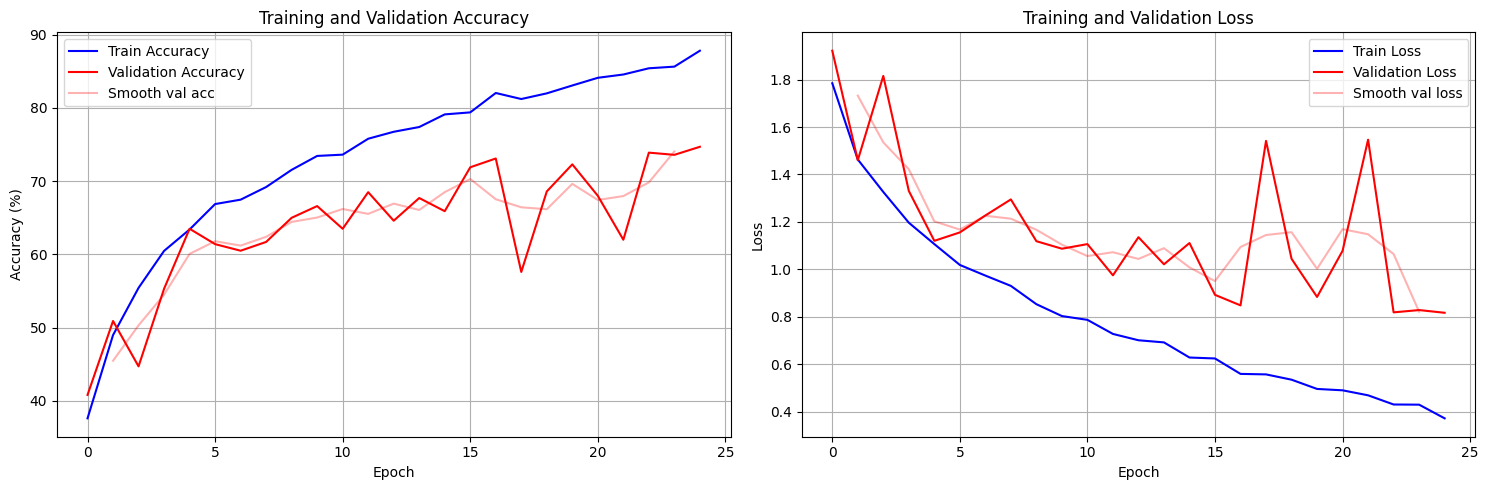

In [101]:
plot_training_history(history_3_3_B)

In [102]:
class Model33C(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64, activation="elu")
        self.basic_block_1_1 = BasicBlock(64, 64, activation="elu")

        self.basic_block_2_0 = BasicBlock(64, 128, 2, activation="elu")
        self.basic_block_2_1 = BasicBlock(128, 128, activation="elu")

        self.basic_block_3_0 = BasicBlock(128, 256, 2, activation="elu")
        self.basic_block_3_1 = BasicBlock(256, 256, activation="elu")

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [103]:
model_3_3_C = Model33C()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_C(test_input)
print(output.shape)

torch.Size([1, 10])


In [104]:
optimizer = torch.optim.Adam(model_3_3_C.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_C = train_model(
    model=model_3_3_C,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33C.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:02<00:00,  7.82it/s]


 Train Loss: 1.8998, Train Acc: 32.05%
 Val Loss: 1.7555, Val Acc: 38.40%
 Сохранена лучшая модель с точностью 38.40%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 10.54it/s]


 Train Loss: 1.5605, Train Acc: 45.95%
 Val Loss: 1.6343, Val Acc: 39.80%
 Сохранена лучшая модель с точностью 39.80%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.41it/s]


 Train Loss: 1.4213, Train Acc: 51.75%
 Val Loss: 1.5167, Val Acc: 49.00%
 Сохранена лучшая модель с точностью 49.00%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.41it/s]


 Train Loss: 1.3129, Train Acc: 54.90%
 Val Loss: 1.5503, Val Acc: 49.30%
 Сохранена лучшая модель с точностью 49.30%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


 Train Loss: 1.2660, Train Acc: 57.52%
 Val Loss: 1.3890, Val Acc: 53.90%
 Сохранена лучшая модель с точностью 53.90%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.54it/s]


 Train Loss: 1.1936, Train Acc: 59.40%
 Val Loss: 1.2183, Val Acc: 57.50%
 Сохранена лучшая модель с точностью 57.50%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.84it/s]


 Train Loss: 1.1094, Train Acc: 62.30%
 Val Loss: 1.1699, Val Acc: 62.50%
 Сохранена лучшая модель с точностью 62.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.43it/s]


 Train Loss: 1.0880, Train Acc: 62.85%
 Val Loss: 1.1213, Val Acc: 64.30%
 Сохранена лучшая модель с точностью 64.30%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


 Train Loss: 1.0214, Train Acc: 66.17%
 Val Loss: 1.1024, Val Acc: 63.60%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


 Train Loss: 0.9764, Train Acc: 67.38%
 Val Loss: 0.9945, Val Acc: 67.20%
 Сохранена лучшая модель с точностью 67.20%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 0.9483, Train Acc: 68.12%
 Val Loss: 1.1072, Val Acc: 64.60%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.15it/s]


 Train Loss: 0.9194, Train Acc: 69.20%
 Val Loss: 1.0720, Val Acc: 64.10%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.55it/s]


 Train Loss: 0.8702, Train Acc: 70.28%
 Val Loss: 1.0047, Val Acc: 67.40%
 Сохранена лучшая модель с точностью 67.40%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.56it/s]


 Train Loss: 0.8408, Train Acc: 71.65%
 Val Loss: 1.0165, Val Acc: 65.90%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


 Train Loss: 0.8077, Train Acc: 73.17%
 Val Loss: 0.9963, Val Acc: 67.90%
 Сохранена лучшая модель с точностью 67.90%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.19it/s]


 Train Loss: 0.7948, Train Acc: 74.25%
 Val Loss: 0.9702, Val Acc: 68.80%
 Сохранена лучшая модель с точностью 68.80%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.99it/s]


 Train Loss: 0.7905, Train Acc: 74.30%
 Val Loss: 1.0308, Val Acc: 68.40%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.84it/s]


 Train Loss: 0.7597, Train Acc: 75.33%
 Val Loss: 0.9567, Val Acc: 68.60%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]


 Train Loss: 0.7175, Train Acc: 76.55%
 Val Loss: 0.9608, Val Acc: 67.40%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.93it/s]


 Train Loss: 0.6906, Train Acc: 77.50%
 Val Loss: 0.8937, Val Acc: 71.50%
 Сохранена лучшая модель с точностью 71.50%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.58it/s]


 Train Loss: 0.6802, Train Acc: 76.90%
 Val Loss: 1.0599, Val Acc: 68.50%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.91it/s]


 Train Loss: 0.6301, Train Acc: 79.12%
 Val Loss: 0.8204, Val Acc: 74.70%
 Сохранена лучшая модель с точностью 74.70%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.86it/s]


 Train Loss: 0.6111, Train Acc: 79.65%
 Val Loss: 0.9671, Val Acc: 69.30%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.23it/s]


 Train Loss: 0.5994, Train Acc: 79.70%
 Val Loss: 0.9345, Val Acc: 71.60%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.87it/s]

 Train Loss: 0.6078, Train Acc: 79.33%
 Val Loss: 0.8013, Val Acc: 72.50%


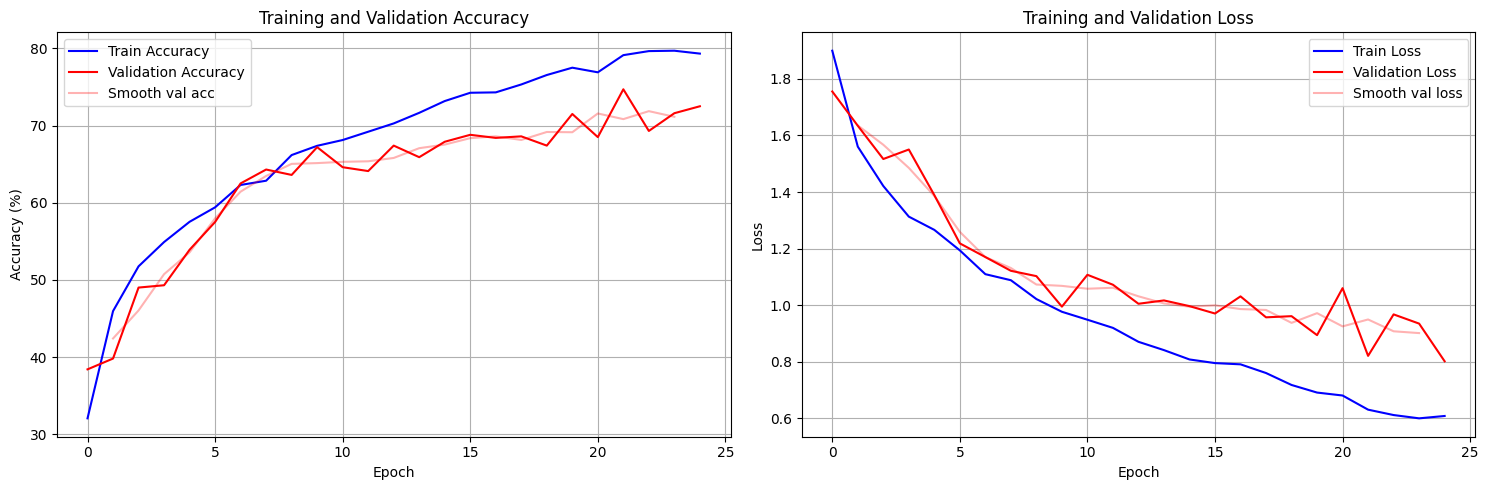

In [105]:
plot_training_history(history_3_3_C)

In [109]:
class Model33D(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.basic_block_1_0 = BasicBlock(3, 64, activation="gelu")
        self.basic_block_1_1 = BasicBlock(64, 64, activation="gelu")

        self.basic_block_2_0 = BasicBlock(64, 128, 2, activation="gelu")
        self.basic_block_2_1 = BasicBlock(128, 128, activation="gelu")

        self.basic_block_3_0 = BasicBlock(128, 256, 2, activation="gelu")
        self.basic_block_3_1 = BasicBlock(256, 256, activation="gelu")

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.basic_block_1_1(self.basic_block_1_0(x))
        x = self.basic_block_2_1(self.basic_block_2_0(x))
        x = self.basic_block_3_1(self.basic_block_3_0(x))

        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [110]:
model_3_3_D = Model33D()
test_input = torch.randn(1, 3, 64, 64)
output = model_3_3_D(test_input)
print(output.shape)

torch.Size([1, 10])


In [111]:
optimizer = torch.optim.Adam(model_3_3_D.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_3_3_D = train_model(
    model=model_3_3_D,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    model_path="model_33D.pth"
)

cuda
Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


 Train Loss: 1.7553, Train Acc: 37.38%
 Val Loss: 1.8062, Val Acc: 39.50%
 Сохранена лучшая модель с точностью 39.50%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.60it/s]


 Train Loss: 1.4743, Train Acc: 48.62%
 Val Loss: 1.5333, Val Acc: 50.70%
 Сохранена лучшая модель с точностью 50.70%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


 Train Loss: 1.3319, Train Acc: 55.30%
 Val Loss: 1.4034, Val Acc: 52.30%
 Сохранена лучшая модель с точностью 52.30%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.84it/s]


 Train Loss: 1.1819, Train Acc: 60.45%
 Val Loss: 1.3647, Val Acc: 55.50%
 Сохранена лучшая модель с точностью 55.50%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.86it/s]


 Train Loss: 1.0880, Train Acc: 63.27%
 Val Loss: 1.2830, Val Acc: 56.50%
 Сохранена лучшая модель с точностью 56.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


 Train Loss: 1.0153, Train Acc: 65.58%
 Val Loss: 1.0792, Val Acc: 64.40%
 Сохранена лучшая модель с точностью 64.40%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.88it/s]


 Train Loss: 0.9316, Train Acc: 68.97%
 Val Loss: 1.1554, Val Acc: 63.40%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


 Train Loss: 0.8908, Train Acc: 70.38%
 Val Loss: 0.9860, Val Acc: 67.90%
 Сохранена лучшая модель с точностью 67.90%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


 Train Loss: 0.8090, Train Acc: 73.65%
 Val Loss: 1.0412, Val Acc: 66.20%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.99it/s]


 Train Loss: 0.7698, Train Acc: 75.10%
 Val Loss: 0.9586, Val Acc: 68.10%
 Сохранена лучшая модель с точностью 68.10%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.73it/s]


 Train Loss: 0.7277, Train Acc: 75.60%
 Val Loss: 0.9821, Val Acc: 69.30%
 Сохранена лучшая модель с точностью 69.30%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.42it/s]


 Train Loss: 0.7071, Train Acc: 76.75%
 Val Loss: 0.9984, Val Acc: 67.20%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


 Train Loss: 0.6319, Train Acc: 78.97%
 Val Loss: 0.9325, Val Acc: 71.00%
 Сохранена лучшая модель с точностью 71.00%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.79it/s]


 Train Loss: 0.6059, Train Acc: 79.47%
 Val Loss: 0.9323, Val Acc: 69.80%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.80it/s]


 Train Loss: 0.5776, Train Acc: 81.25%
 Val Loss: 0.9822, Val Acc: 68.20%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


 Train Loss: 0.5476, Train Acc: 81.50%
 Val Loss: 1.1087, Val Acc: 66.00%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


 Train Loss: 0.5164, Train Acc: 82.62%
 Val Loss: 0.7495, Val Acc: 76.50%
 Сохранена лучшая модель с точностью 76.50%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


 Train Loss: 0.4924, Train Acc: 84.08%
 Val Loss: 0.7566, Val Acc: 75.70%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 0.4447, Train Acc: 85.20%
 Val Loss: 0.7123, Val Acc: 76.10%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


 Train Loss: 0.4155, Train Acc: 86.38%
 Val Loss: 0.8559, Val Acc: 72.60%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.82it/s]


 Train Loss: 0.3779, Train Acc: 87.75%
 Val Loss: 0.7860, Val Acc: 73.90%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


 Train Loss: 0.3494, Train Acc: 88.45%
 Val Loss: 0.7702, Val Acc: 75.50%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.48it/s]


 Train Loss: 0.3300, Train Acc: 89.10%
 Val Loss: 0.9161, Val Acc: 74.00%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.85it/s]


 Train Loss: 0.3352, Train Acc: 88.95%
 Val Loss: 0.7799, Val Acc: 75.80%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.63it/s]

 Train Loss: 0.2937, Train Acc: 90.28%
 Val Loss: 0.8055, Val Acc: 76.50%


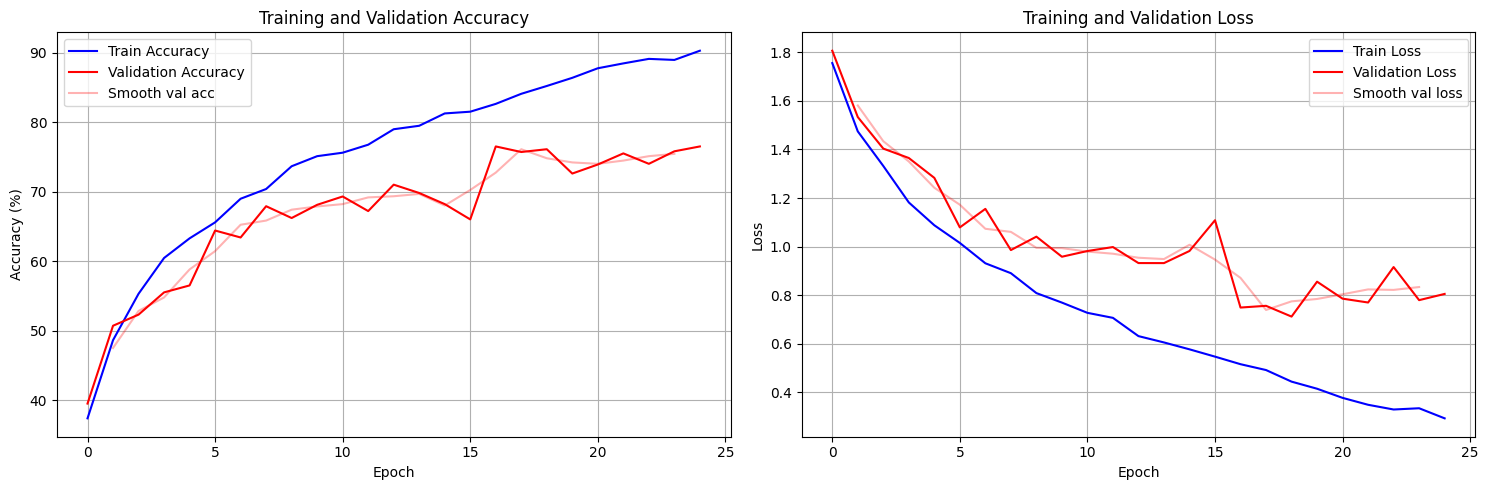

In [112]:
plot_training_history(history_3_3_D)

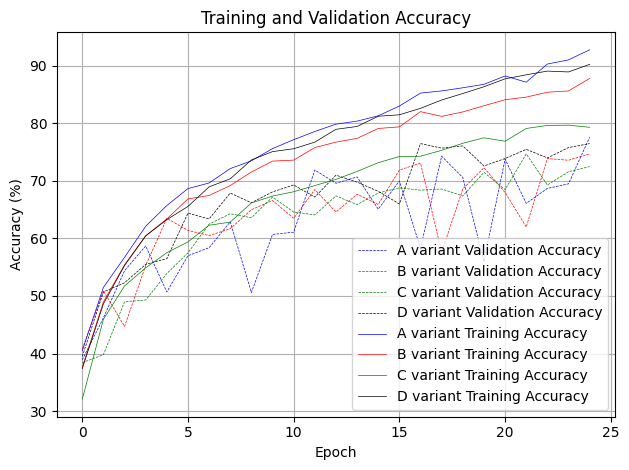

In [114]:
plt.plot(history_3_1_B['val_acc'], label='A variant Validation Accuracy', color='blue', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_B['val_acc'], label='B variant Validation Accuracy', color='red', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_C['val_acc'], label='C variant Validation Accuracy', color='green', linewidth=0.5, linestyle="dashed")
plt.plot(history_3_3_D['val_acc'], label='D variant Validation Accuracy', color='black', linewidth=0.5, linestyle="dashed")

plt.plot(history_3_1_B['train_acc'], label='A variant Training Accuracy', color='blue', linewidth=0.5)
plt.plot(history_3_3_B['train_acc'], label='B variant Training Accuracy', color='red', linewidth=0.5)
plt.plot(history_3_3_C['train_acc'], label='C variant Training Accuracy', color='green', linewidth=0.5)
plt.plot(history_3_3_D['train_acc'], label='D variant Training Accuracy', color='black', linewidth=0.5)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

| Этап | Конфигурация  | Параметры     | Val Accuracy (%) |Train Accuracy (%) |Эпоха с лучшим результатом|
|------|---------------|---------------|------------------|-------------------|--------------------------|
| 3.3  |3.3-A          | 2 741 002     | 77.6             | 92.8              |25                        |
| 3.3  |3.3-B          | 2 741 002     | 74.7             | 87.83             |25                        |
| 3.3  |3.3-C          | 2 741 002     | 74.7             | 79.12             |22                        |
| 3.3  |3.3-D          | 2 741 002     | 76.5             | 82.62             |17                        |

**Вывод:** ReLU и GeLU показали сравнимые результаты, они обе являются хорошим выбором. Но ReLU показала наивысшую валидационную точность, превзойдя другие функции активации. Поэтому для данной архитектуры ReLU — оптимальный выбор.

## Часть 4: Финальная модель и тестирование

### 4.1: Создание финальной модели

In [139]:
model_final = Model31B()

In [140]:
optimizer = torch.optim.Adam(model_final.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

history_final = train_model(
    model=model_final,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    model_path="model_final.pth"
)

cuda
Обучение на 40 эпох...
 Эпоха 1/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


 Train Loss: 1.7551, Train Acc: 38.60%
 Val Loss: 1.9097, Val Acc: 41.90%
 Сохранена лучшая модель с точностью 41.90%
 Эпоха 2/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 13.40it/s]


 Train Loss: 1.4309, Train Acc: 51.73%
 Val Loss: 1.6311, Val Acc: 45.90%
 Сохранена лучшая модель с точностью 45.90%
 Эпоха 3/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


 Train Loss: 1.2797, Train Acc: 57.38%
 Val Loss: 2.0963, Val Acc: 43.20%
 Эпоха 4/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.34it/s]


 Train Loss: 1.1873, Train Acc: 60.20%
 Val Loss: 1.3373, Val Acc: 55.10%
 Сохранена лучшая модель с точностью 55.10%
 Эпоха 5/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.80it/s]


 Train Loss: 1.1033, Train Acc: 63.42%
 Val Loss: 1.3037, Val Acc: 57.00%
 Сохранена лучшая модель с точностью 57.00%
 Эпоха 6/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.66it/s]


 Train Loss: 1.0215, Train Acc: 66.60%
 Val Loss: 1.2196, Val Acc: 62.90%
 Сохранена лучшая модель с точностью 62.90%
 Эпоха 7/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


 Train Loss: 0.9321, Train Acc: 68.62%
 Val Loss: 1.0952, Val Acc: 62.60%
 Эпоха 8/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.72it/s]


 Train Loss: 0.9221, Train Acc: 69.47%
 Val Loss: 1.1953, Val Acc: 60.30%
 Эпоха 9/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 10.34it/s]


 Train Loss: 0.8664, Train Acc: 71.05%
 Val Loss: 1.0487, Val Acc: 66.30%
 Сохранена лучшая модель с точностью 66.30%
 Эпоха 10/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.61it/s]


 Train Loss: 0.8071, Train Acc: 74.03%
 Val Loss: 0.9222, Val Acc: 68.50%
 Сохранена лучшая модель с точностью 68.50%
 Эпоха 11/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.61it/s]


 Train Loss: 0.7464, Train Acc: 75.17%
 Val Loss: 1.0387, Val Acc: 65.90%
 Эпоха 12/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.19it/s]


 Train Loss: 0.7304, Train Acc: 75.95%
 Val Loss: 1.0276, Val Acc: 68.20%
 Эпоха 13/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.41it/s]


 Train Loss: 0.6942, Train Acc: 76.60%
 Val Loss: 0.9830, Val Acc: 69.50%
 Сохранена лучшая модель с точностью 69.50%
 Эпоха 14/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.48it/s]


 Train Loss: 0.6855, Train Acc: 76.90%
 Val Loss: 1.1441, Val Acc: 65.70%
 Эпоха 15/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


 Train Loss: 0.6109, Train Acc: 79.28%
 Val Loss: 0.9350, Val Acc: 70.40%
 Сохранена лучшая модель с точностью 70.40%
 Эпоха 16/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.57it/s]


 Train Loss: 0.5676, Train Acc: 80.78%
 Val Loss: 0.9476, Val Acc: 67.60%
 Эпоха 17/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


 Train Loss: 0.5502, Train Acc: 81.72%
 Val Loss: 1.2994, Val Acc: 64.50%
 Эпоха 18/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.58it/s]


 Train Loss: 0.5264, Train Acc: 82.50%
 Val Loss: 0.9803, Val Acc: 68.30%
 Эпоха 19/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.80it/s]


 Train Loss: 0.5203, Train Acc: 82.20%
 Val Loss: 0.9186, Val Acc: 70.50%
 Сохранена лучшая модель с точностью 70.50%
 Эпоха 20/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.52it/s]


 Train Loss: 0.4833, Train Acc: 83.95%
 Val Loss: 1.1122, Val Acc: 66.10%
 Эпоха 21/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.64it/s]


 Train Loss: 0.4583, Train Acc: 84.10%
 Val Loss: 0.8524, Val Acc: 75.00%
 Сохранена лучшая модель с точностью 75.00%
 Эпоха 22/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.76it/s]


 Train Loss: 0.4381, Train Acc: 85.25%
 Val Loss: 1.0053, Val Acc: 68.90%
 Эпоха 23/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.71it/s]


 Train Loss: 0.4461, Train Acc: 85.58%
 Val Loss: 1.0995, Val Acc: 65.50%
 Эпоха 24/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.65it/s]


 Train Loss: 0.3758, Train Acc: 87.60%
 Val Loss: 0.8006, Val Acc: 76.30%
 Сохранена лучшая модель с точностью 76.30%
 Эпоха 25/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.63it/s]


 Train Loss: 0.3519, Train Acc: 88.50%
 Val Loss: 0.9246, Val Acc: 74.60%
 Эпоха 26/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 0.3490, Train Acc: 88.78%
 Val Loss: 0.8564, Val Acc: 73.60%
 Эпоха 27/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.48it/s]


 Train Loss: 0.3188, Train Acc: 89.35%
 Val Loss: 0.9944, Val Acc: 74.80%
 Эпоха 28/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 0.3105, Train Acc: 89.75%
 Val Loss: 0.8329, Val Acc: 74.90%
 Эпоха 29/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.83it/s]


 Train Loss: 0.2908, Train Acc: 90.53%
 Val Loss: 1.1442, Val Acc: 71.20%
 Эпоха 30/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.68it/s]


 Train Loss: 0.2318, Train Acc: 92.78%
 Val Loss: 0.8700, Val Acc: 77.10%
 Сохранена лучшая модель с точностью 77.10%
 Эпоха 31/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


 Train Loss: 0.1953, Train Acc: 93.78%
 Val Loss: 0.9020, Val Acc: 73.80%
 Эпоха 32/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.96it/s]


 Train Loss: 0.1607, Train Acc: 95.28%
 Val Loss: 0.7396, Val Acc: 78.90%
 Сохранена лучшая модель с точностью 78.90%
 Эпоха 33/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.62it/s]


 Train Loss: 0.1985, Train Acc: 93.62%
 Val Loss: 0.8436, Val Acc: 76.70%
 Эпоха 34/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


 Train Loss: 0.1841, Train Acc: 93.85%
 Val Loss: 0.9467, Val Acc: 75.50%
 Эпоха 35/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.67it/s]


 Train Loss: 0.1434, Train Acc: 95.92%
 Val Loss: 0.9810, Val Acc: 74.30%
 Эпоха 36/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.46it/s]


 Train Loss: 0.1503, Train Acc: 95.17%
 Val Loss: 1.4509, Val Acc: 67.30%
 Эпоха 37/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.36it/s]


 Train Loss: 0.1436, Train Acc: 95.78%
 Val Loss: 0.9390, Val Acc: 74.70%
 Эпоха 38/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.58it/s]


 Train Loss: 0.1227, Train Acc: 96.15%
 Val Loss: 0.7415, Val Acc: 78.10%
 Эпоха 39/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


 Train Loss: 0.1225, Train Acc: 96.30%
 Val Loss: 1.1266, Val Acc: 74.50%
 Эпоха 40/40


Validation: 100%|██████████| 16/16 [00:01<00:00, 14.32it/s]

 Train Loss: 0.1205, Train Acc: 96.40%
 Val Loss: 1.1880, Val Acc: 71.10%


### 4.2: Тестирование на test set

In [142]:
all_preds = []
all_labels = []

model_final = model_final.to(device)
model_final.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        predicted = model_final(data)
        _, preds = torch.max(predicted, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

In [143]:
acc = accuracy_score(all_labels, all_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

print(f"Test Accuracy: {acc:.4f}")
print("\nPer-class metrics:")
for i in range(len(selected_classes)):
    print(f"Class {class_names_human[i]:30}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Test Accuracy: 0.7100

Per-class metrics:
Class tabby                         : Precision=0.6531, Recall=0.6400, F1=0.6465
Class goldfish                      : Precision=0.8704, Recall=0.9400, F1=0.9038
Class European fire salamander      : Precision=0.8462, Recall=0.8800, F1=0.8627
Class bee                           : Precision=0.7963, Recall=0.8600, F1=0.8269
Class sports car                    : Precision=0.7797, Recall=0.9200, F1=0.8440
Class lemon                         : Precision=0.9310, Recall=0.5400, F1=0.6835
Class cliff                         : Precision=0.6056, Recall=0.8600, F1=0.7107
Class computer keyboard             : Precision=0.9091, Recall=0.2000, F1=0.3279
Class beer bottle                   : Precision=0.5059, Recall=0.8600, F1=0.6370
Class projectile                    : Precision=0.5556, Recall=0.4000, F1=0.4651


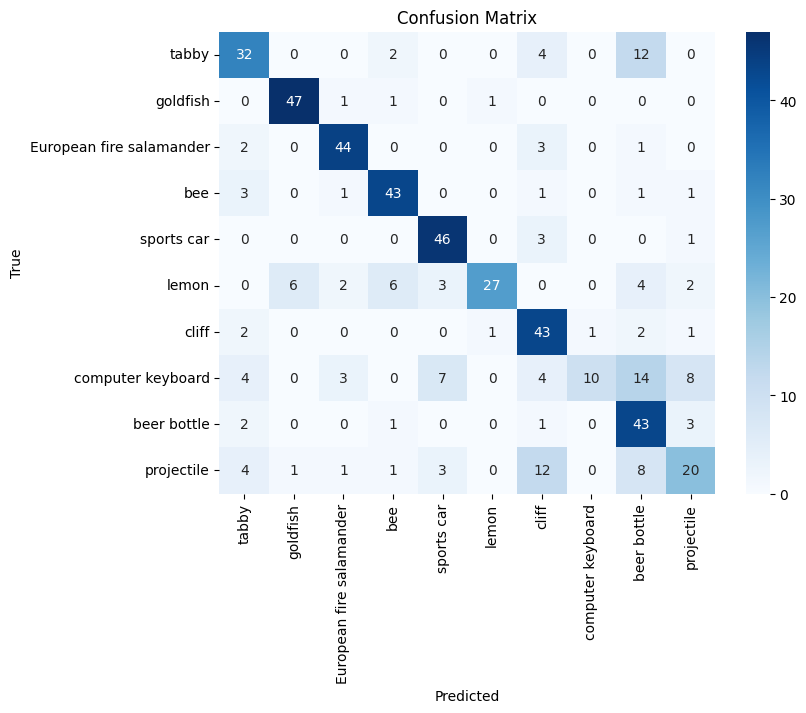

In [144]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_human,
            yticklabels=class_names_human)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 4.3: Визуальный анализ

In [151]:
indices = np.random.choice(len(test_subset_dataset), size=10, replace=False)

sample_images = []
sample_true_labels = []
sample_pred_labels = []

with torch.no_grad():
    for idx in indices:
        data, target = test_subset_dataset[idx]
        sample_images.append(data)
        sample_true_labels.append(target)

        predicted = model_final(data.unsqueeze(0).to(device))
        pred = torch.argmax(predicted, dim=1).item()
        sample_pred_labels.append(pred)

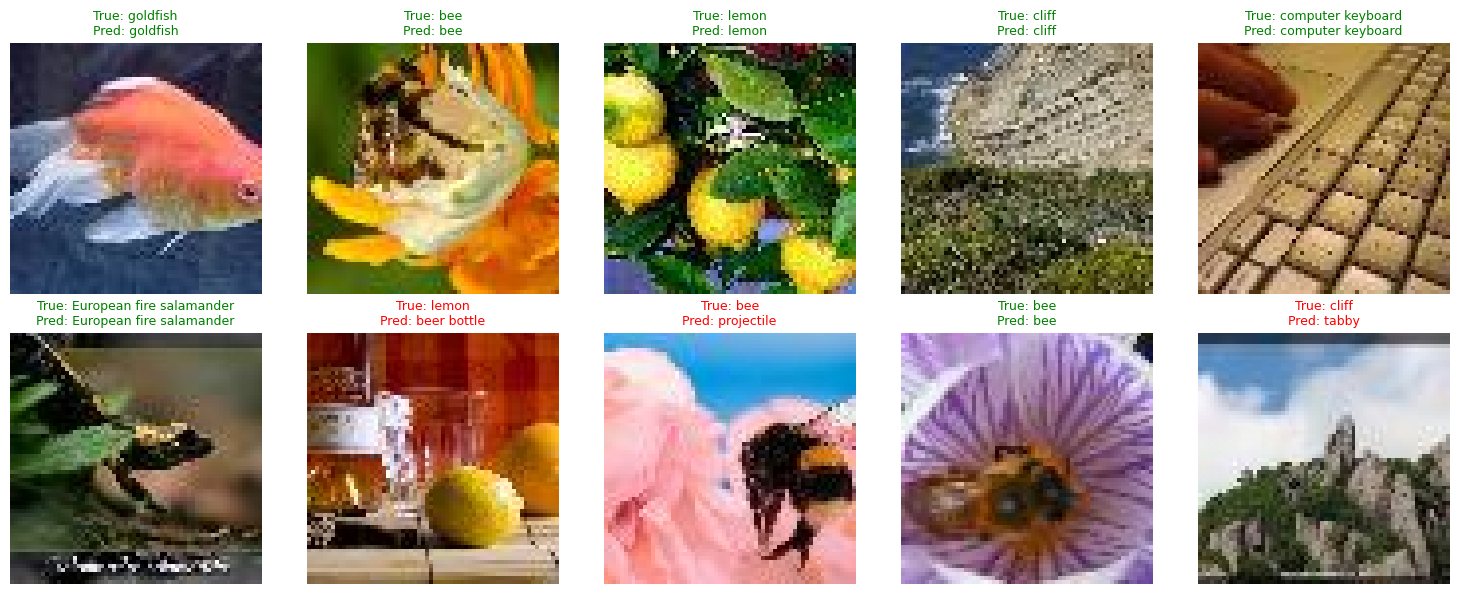

In [152]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

for i in range(10):
    ax = axes[i]
    img = sample_images[i]
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()

    ax.imshow(img)
    true_cls = sample_true_labels[i]
    pred_cls = sample_pred_labels[i]
    color = 'green' if true_cls == pred_cls else 'red'
    true_name = class_names_human[true_cls]
    pred_name = class_names_human[pred_cls]
    ax.set_title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 4.4: Сравнительная таблица всех экспериментов

| Этап        | Конфигурация                          | Параметры   | Val Accuracy | Train Accuracy |
|-------------|---------------------------------------|-------------|--------------|----------------|
| Baseline    | BaseModel (ReLU, 4 блока, 200→256)    | 4.79M       | **73.5%**    | **92.45%**     |
| 3.1-A       | Каналы: 32→64→128→256                 | 2.79M       | 72.6%        | 97.83%         |
| 3.1-B       | Каналы: 64→128→256                    | 2.74M       | **77.6%**    | **92.80%**     |
| 3.2-A       | [1,1,1] блоков                        | 1.19M       | 76.7%        | 90.42%         |
| 3.2-B       | [2,2,2] блоков                        | 2.74M       | **77.6%**    | **92.80%**     |
| 3.2-C       | [3,3,3] блоков                        | 4.29M       | 74.7%        | 94.08%         |
| 3.3-A       | ReLU                                  | 2.74M       | 77.6%        | 92.80%         |
| 3.3-B       | LeakyReLU                             | 2.74M       | 74.7%    | 87.83%         |
| 3.3-C       | ELU                                   | 2.74M       | 74.7%    | 79.12%         |
| 3.3-D       | GELU                                  | 2.74M       | **76.5%**    | **82.62%**     |
| Final       | **ReLU + [2,2,2] + 64→128→256** (40 эпох) | **2.74M**   | **78.9%**    | **95.28%**     |

**Вывод:** лучший результат показала модель с архитектурой ReLU + [2,2,2] residual-блока + каналы 64→128→256, обученная 40 эпох, достигнув валидационной точности 78.9%.

Разница между тренировочной (95.28%) и валидационной (78.9%) точностью составляет около 16.4 процентных пунктов, что указывает на умеренное переобучение. Однако, поскольку валидационная точность продолжает расти, это переобучение не критично и модель сохраняет хорошую обобщающую способность.